In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
results_df = pd.read_csv('data/13_estimation_results/Sumatra_multiple_models_cross_validation_results_sorted.csv')
len(results_df)

1496

In [5]:
summary_stats = results_df[['r2_score', 'rmse', 'pearson_r']].describe()
summary_stats

,r2_score,rmse,pearson_r
count,1.496000e+03,1.496000e+03,1496.000000
mean,-9.048390e+22,1.642448e+11,0.375754
std,3.486806e+24,5.523242e+12,0.253651
min,-1.348633e+26,3.115526e+00,-0.925825
25%,-4.274265e-01,1.034866e+01,0.251369
50%,1.453568e-02,1.305922e+01,0.396203
75%,2.152264e-01,1.773898e+01,0.531289
max,8.745623e-01,2.128056e+14,0.943669


In [6]:
# Performance by model type
model_performance = results_df.groupby('estimator_name')[['r2_score', 'rmse', 'pearson_r']].mean()
model_performance

,r2_score,rmse,pearson_r
estimator_name,,,
GradientBoostingRegressor,-2.333265e-01,1.432937e+01,0.427570
LinearRegression,-3.619356e+23,6.569793e+11,0.337728
RandomForestRegressor,-2.792200e-01,1.427939e+01,0.439731
Sequential,-5.156199e+00,2.306545e+01,0.297987


In [7]:
# Analyze performance by split type
split_performance = results_df.groupby('validation')[['r2_score', 'rmse', 'pearson_r']].mean()
split_performance


,r2_score,rmse,pearson_r
validation,,,
cross validation id,-2.697265e+23,4.256112e+11,0.360051
cross validation month,9.431480e-02,1.300460e+01,0.481370
cross validation year,-1.043005e+21,6.855134e+10,0.278574


In [8]:
# Calculating mean R2 and RMSE for each PHU
phu_split_performance = results_df.groupby(['phu_id', 'validation']).agg({
    'r2_score': 'mean',
    'rmse': 'mean',
    'no_obs': 'sum'  # Total number of observations for each PHU
}).reset_index()
# Sort by R2 score
phu_split_performance.sort_values(by='r2_score', ascending=False, inplace=True)
# don't show the exponential notation
pd.options.display.float_format = '{:.4f}'.format
# phu_split_performance.head()
phu_split_performance

,phu_id,validation,r2_score,rmse,no_obs
25,149.0000,cross validation month,0.4895,20.2269,4860
28,152.0000,cross validation month,0.3946,15.9100,34440
19,120.0000,cross validation month,0.2944,12.8747,37680
16,119.0000,cross validation month,0.2731,12.3493,299080
36,188.0000,cross validation id,0.2258,11.8257,303800
4,71.0000,cross validation month,0.1802,11.1836,108080
15,119.0000,cross validation id,0.1574,13.0483,299080
13,115.0000,cross validation month,0.1500,9.0445,97160
3,71.0000,cross validation id,0.1487,12.0923,108080
7,99.0000,cross validation month,0.1297,16.4353,16880


## Train the model

In [14]:
from gee_scripts.parameters import explain_vars
from gee_scripts.models import get_random_forest, get_regressors
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_squared_error
from gee_scripts.plots import plot_observed_vs_predicted

import seaborn as sns


In [24]:
df = pd.read_csv("data/9_clean_training_data/all_training_data_with_extra_and_locations_and_precipSum.csv", parse_dates=["date"])
len(df)

31547

In [36]:
data = df[df.phu_id.isin([297.0, 351.0, 352.0, 256.0, 340.0])]
len(data)

3575

In [35]:
data.shape[1]

50

/tmp/ipykernel_675298/3470781767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df['Target'] = data["gwl_cm"]


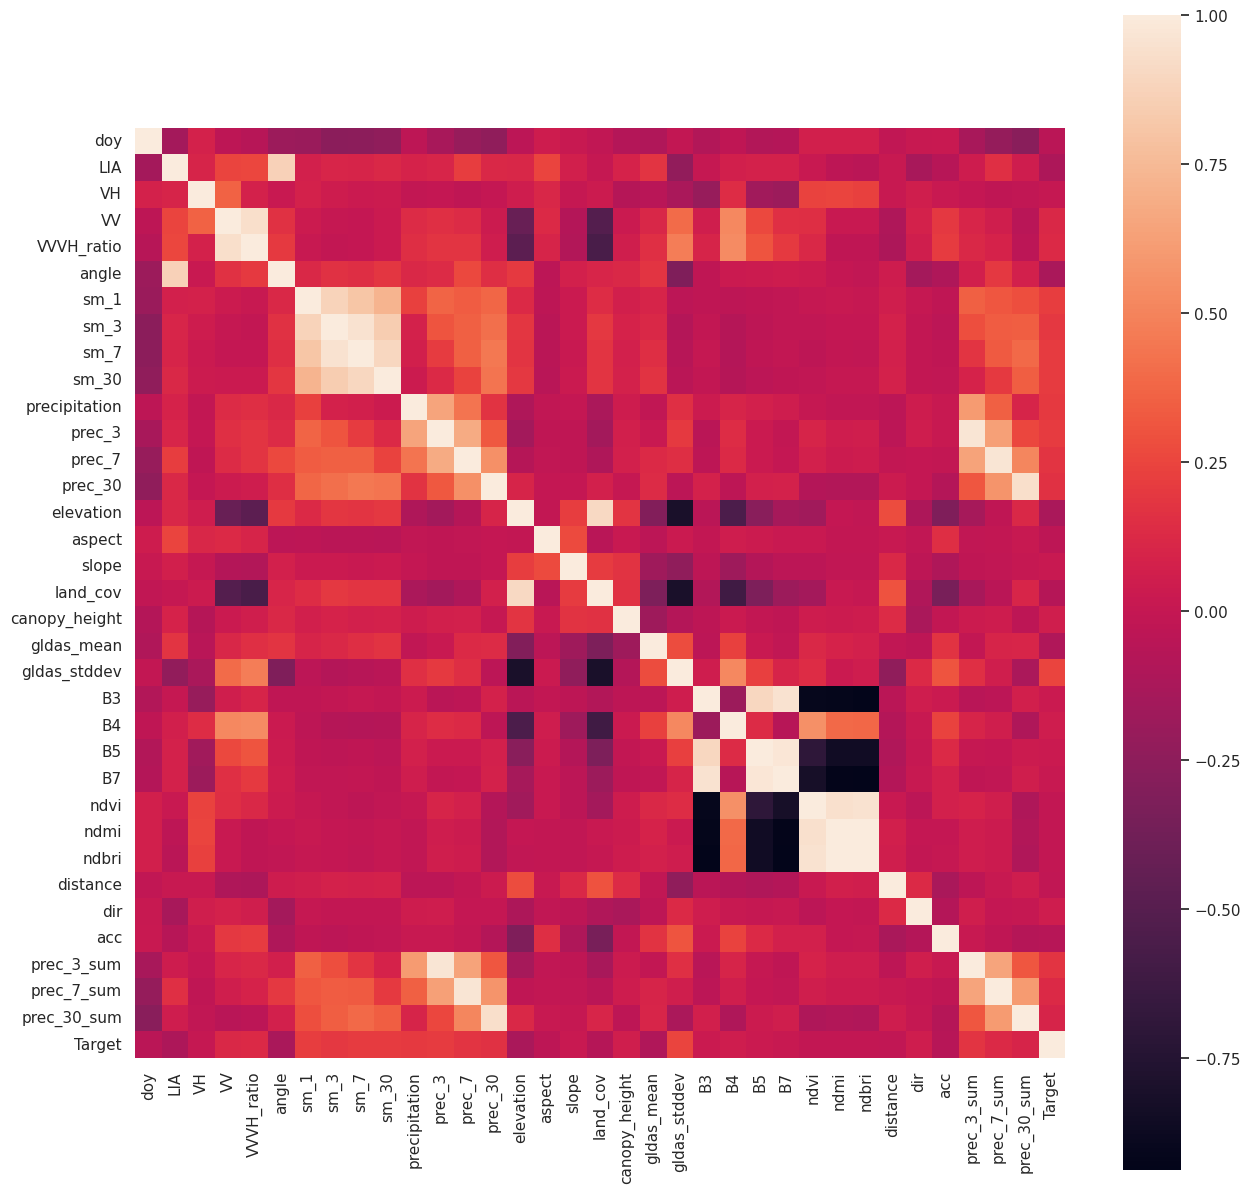

In [28]:
corr_df = data[explain_vars]
corr_df['Target'] = data["gwl_cm"]

C_mat = corr_df.corr()
fig = plt.figure(figsize = (15,15))

sns.heatmap(C_mat, square = True)
plt.show()


lenght of train and test 2658 917
r2_score: 0.5857387342638005
rmse: 10.660476879845612
pearson r: 0.7697474352733138
p-value: 1.4534542480013616e-180


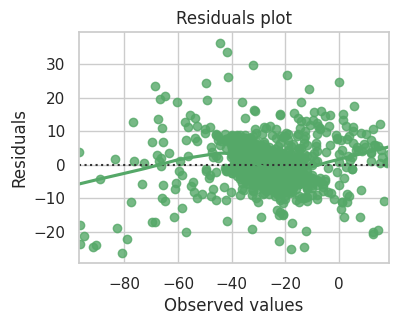

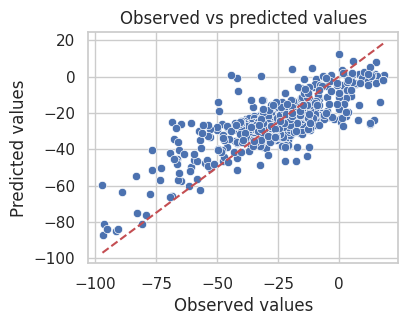

In [15]:
# PCA TEST
# Divide train and test by PCA and year
# train_data = data[data["date"].dt.year.isin([2020,2021,2022])]
# test_data = data[data["date"].dt.year.isin([2023])]

# # Divide train and test by PCA and month


train_data = data[data["date"].dt.month.isin([1,2,4,5,7,8,10,11,12])]
test_data = data[data["date"].dt.month.isin([3,6,9,])]

X_train, X_test = train_data[explain_vars], test_data[explain_vars]
y_train, y_test = train_data["gwl_cm"], test_data["gwl_cm"]

print("lenght of train and test", len(X_train), len(X_test))

####################### TRAIN

regr = get_random_forest()

regr.fit(X_train, y_train)
y_pred_test = regr.predict(X_test)

r, p = pearsonr(y_test, y_pred_test)
r2_score_val = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# print all the metrics
print(f"r2_score: {r2_score_val}")
print(f"rmse: {rmse}")
print(f"pearson r: {r}")
print(f"p-value: {p}")

plot_observed_vs_predicted(y_test, y_pred_test, "Observed vs Predicted GWL")


In [12]:
from gee_scripts.models import bootstrap

In [13]:
bootrap_result = bootstrap(data, "gwl_cm", 100, 0.8, explain_vars)
bootrap_result

Training with 3575 observations


,mean,min,max,median
r,0.8327,0.7633,0.8735,0.8340
r2,0.6868,0.5787,0.7485,0.6895
rmse,9.4594,8.5915,10.8777,9.4227
samples_train,2860.0000,2860.0000,2860.0000,NaN
samples_test,715.0000,715.0000,715.0000,NaN
